# Учебная задача «Анализ сайта»

Компания «СберАвтоподписка» хочет увеличить эффективность сайта: улучшить пользовательский опыт, повысить конверсию, сделать рекламные кампании более результативными. Для этого вам предстоит **создать модель, которая предсказывает вероятность того, что пользователь совершит целевое действие (оставит заявку, закажет звонок и пр.) на сайте**.

Эта модель поможет:
- Оценивать эффективность каналов привлечения трафика;
- Адаптировать рекламные кампании;
- Улучшать UX сайта за счет анализа поведения пользователей.

# Выбор моделей

Решается задача бинарной классификации, в нашем датасете большинство признаков категориальные, имеется выраженный дисбаланс классов.  

Учитывая это:
- в качестве baseline-моделей используем: 
    - линейную модель (логистическая регрессия), скорее всего метрики будут наихудшими
    - ансамблевые "деревянные" модели (CatBoost, Gradient Boosting, LightGBM) - они отличаются между собой по построению деревьев, оптимизации, скорости работы
- в качестве метрик будем использовать прежде всего ROC-AUC (как указанную в задании), однако будем также ориентироваться на PR-AUC, Average Precision
- будем решать проблемму дисбаланса классов

# Подготовка к моделированию

Импортируем библиотеки.

In [104]:
# импорт библиотек

import pandas as pd 
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    cross_val_predict, 
    StratifiedKFold)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_recall_curve, 
    roc_curve, 
    auc, 
    average_precision_score, 
    roc_auc_score
)
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

import optuna

import joblib
import pickle

import matplotlib.pyplot as plt
# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

import warnings
warnings.filterwarnings('ignore')

Напишем функцию для анализа обученной модели.

In [105]:
def model_analysis(model, X_test, y_test, probabilities=True):
    '''
    Функция получает предсказание обученной модели на тестовой выборке,
    расчитывает и выводит метрики ROC-AUC, PR-AUC, AP.
    Визуализирует ROC-curve и PR-curve.
    
    Аргументы:
        model: обученная модель
        X_test: наблюдения тестовой выборки
        y_test: метки класов тестовой выборки
        probabilities: если True, то расчитываем вероятности принадлежности классу 1,
                       если False, то просто предсказываем класс
    '''
    if probabilities:
        # предсказываем вероятности для класса 1
        y_pred = model.predict_proba(X_test)[:, 1]
    else:
        # получаем предсказание модели без вероятностей 
        y_pred = model.predict(X_test)
        
    ## Расчитываем метрики

    # --- ROC-AUC ---
    fpr, tpr, _ = roc_curve(y_test, y_pred)  # False Positive Rate, True Positive Rate
    roc_auc = roc_auc_score(y_test, y_pred)  # площадь под ROC-кривой

    # --- PR-AUC-AP ---
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)  # площадь под PR-кривой
    average_precision = average_precision_score(y_test, y_pred)  

    ## Вывод метрик
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Average Precision: {average_precision:.4f}")

    ## Визуализация метрик

    # --- Визуализация ROC-кривой ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Случайный классификатор
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    # --- Визуализация PR-кривой ---
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Зафиксируем `random_state` для воспроизводимости.

In [106]:
# для воспроизводимости результатов
RANDOM_STATE = 42

Загрузим датасет и определим числовые и категориальные признаки.

In [108]:
# загрузка датасета
df = pd.read_csv('data/dataset_for_ml.csv')

# выбираем категориальные признаки
cat_features = df.nunique()[3:].index.to_list()
# выбираем числовые признаки
num_features = df.nunique()[:2].index.to_list()

# Логистическая регрессия

Для логистической регрессии используем One-Hot Encoding для категориальных признаков.

In [109]:
## работа с признаками

# разделение на признаки и целевую переменную
X = df.drop('target', axis=1)
y = df['target']

# разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y  
)

# препроцессинг
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

## Baseline

Инициализируем простую логистическую регрессию с параметрами по умолчанию.

In [110]:
# создание пайплайна 
model = make_pipeline(
    # обработка данных
    preprocessor,
    # baseline модель логистической регрессии
    LogisticRegression(
        class_weight='balanced',
        random_state=RANDOM_STATE
    )
)

In [111]:
%%time
# обучение модели
model.fit(X_train, y_train)

CPU times: user 4.57 s, sys: 545 ms, total: 5.12 s
Wall time: 5.21 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['event_categories_number',
                                                   'hit_number_median']),
                                                 ('cat', OneHotEncoder(),
                                                  ['top_car_brand',
                                                   'visit_number', 'utm_source',
                                                   'utm_medium',
                                                   'device_category',
                                                   'device_brand',
                                                   'device_browser',
                                                   'geo_country', 'geo_city',
                                                   'month', 'day_of_week',
                                                   'time_of_day',
                                                   'top_car_brand_visit_number_1_1.0',
                                                   'top_car_brand_device_category_1_mobile_device',
                                                   'top_car_brand_geo_country_1_russia',
                                                   'geo_country_month_russia_10'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

ROC-AUC: 0.7973
PR-AUC: 0.1739
Average Precision: 0.1739


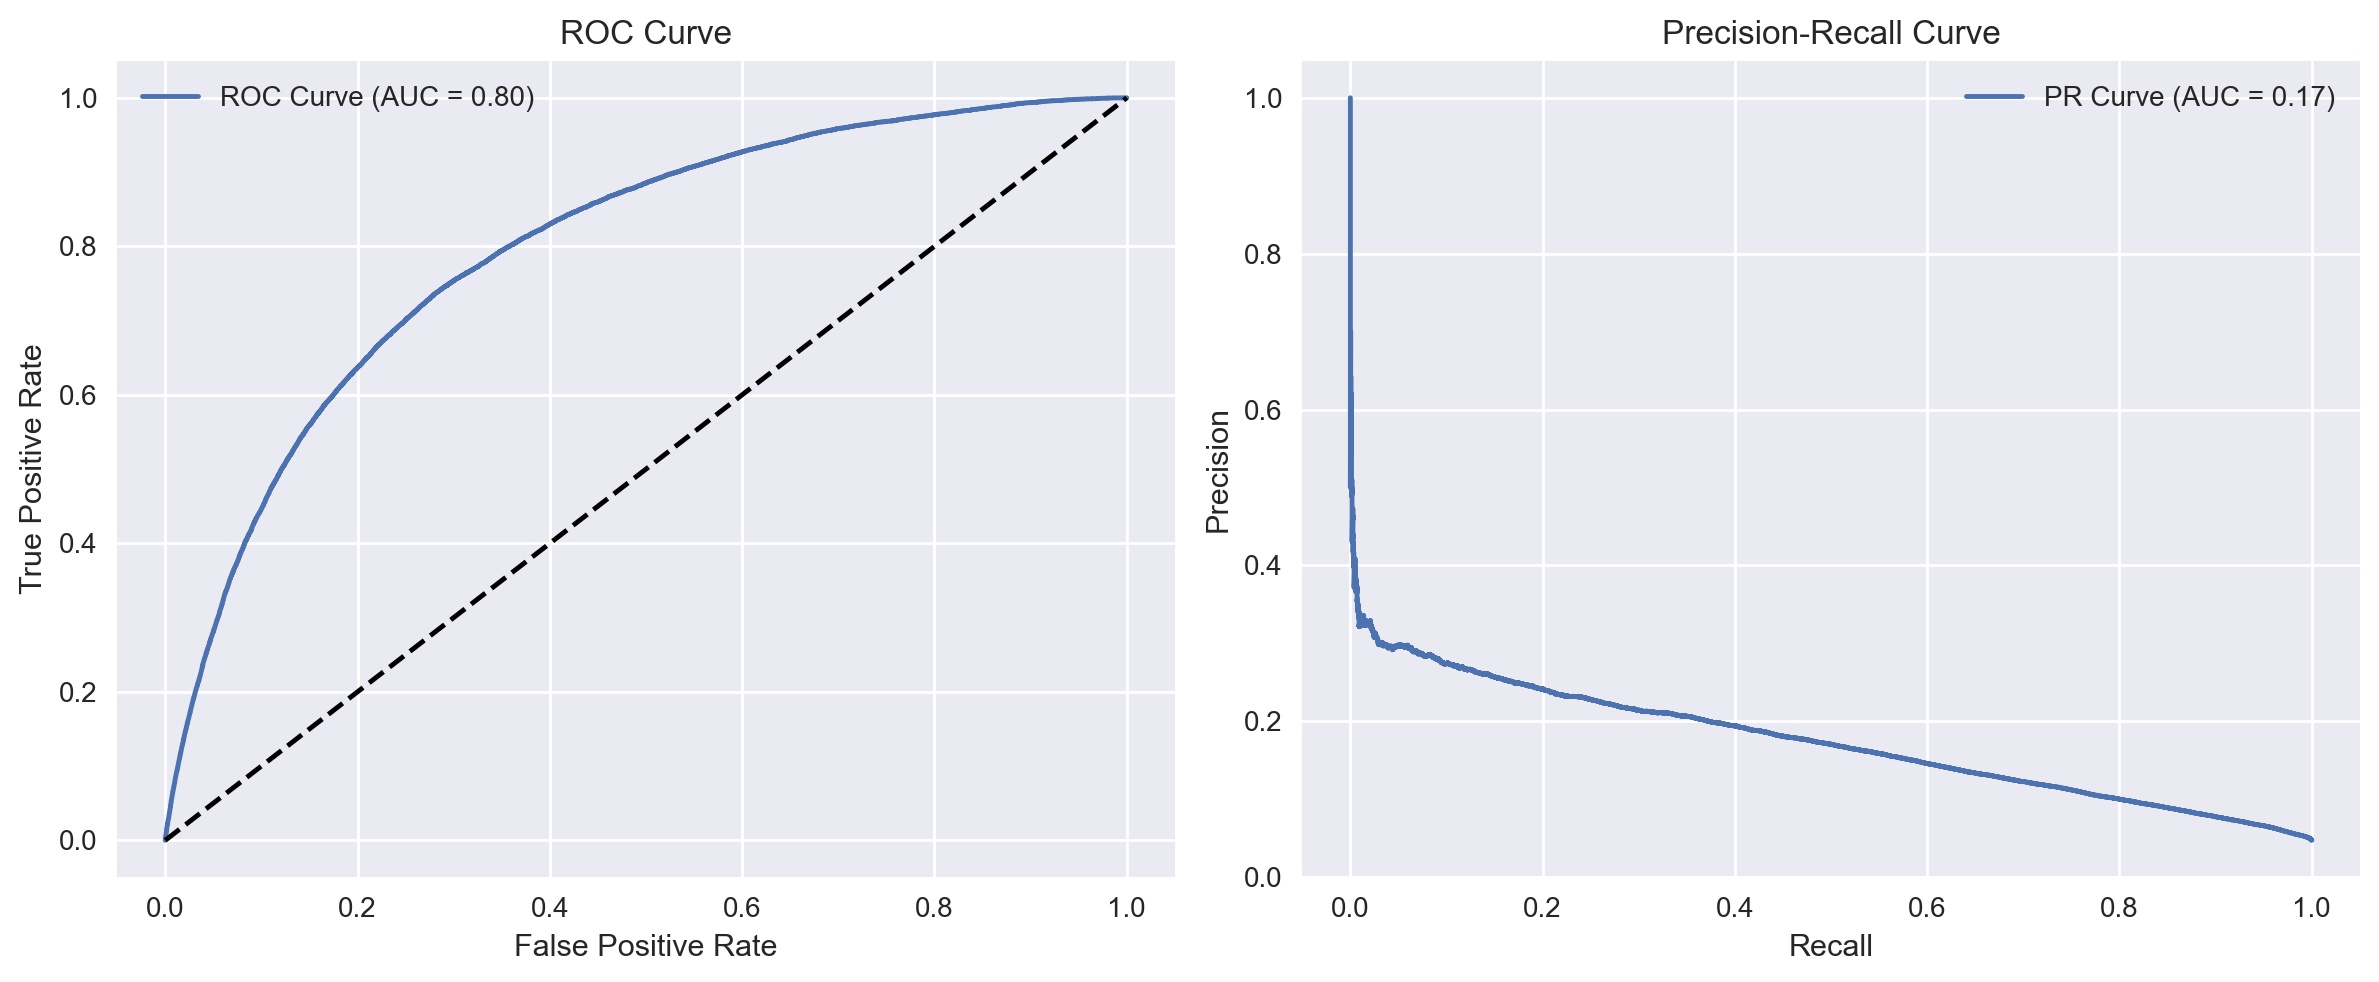

In [113]:
# анализ качества модели
model_analysis(model, X_test, y_test)

## Подбор гиперпараметров

In [114]:
# Функция для оптимизации гиперпараметров через Optuna
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.1, 1, log=False),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'solver': trial.suggest_categorical('solver', ['sag', 'saga', 'newton-cg', 'newton-cholesky']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
        'max_iter': trial.suggest_int('max_iter', 10000, 10000)
    }
    
    model = make_pipeline(
        # обработка данных
        preprocessor,
        # baseline модель логистической регрессии
        LogisticRegression(
            **params,
            random_state=RANDOM_STATE
        )
    )
    
    # используем кросс-валидацию на тренировочных данных
    y_proba = cross_val_predict(
        model, X_train, y_train, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        method='predict_proba',
        n_jobs=-1
    )[:, 1]
    
    return roc_auc_score(y_train, y_proba)

In [115]:
%%time
# Оптимизация
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2025-05-21 18:18:13,512] A new study created in memory with name: no-name-adb13c79-e913-47f1-9282-8b03afd6eaa4
Best trial: 0. Best value: 0.797107:  10%|█         | 1/10 [02:15<20:16, 135.22s/it]

[I 2025-05-21 18:20:28,737] Trial 0 finished with value: 0.7971074872869084 and parameters: {'C': 0.7590788588916417, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 0 with value: 0.7971074872869084.


Best trial: 1. Best value: 0.797108:  20%|██        | 2/10 [02:27<08:21, 62.65s/it] 

[I 2025-05-21 18:20:40,596] Trial 1 finished with value: 0.7971080406339032 and parameters: {'C': 0.9241587599867519, 'penalty': 'l2', 'solver': 'newton-cg', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 1 with value: 0.7971080406339032.


Best trial: 2. Best value: 0.797111:  30%|███       | 3/10 [02:37<04:32, 38.95s/it]

[I 2025-05-21 18:20:51,332] Trial 2 finished with value: 0.7971113179422481 and parameters: {'C': 0.24876732002755675, 'penalty': 'l2', 'solver': 'newton-cg', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 2 with value: 0.7971113179422481.


Best trial: 2. Best value: 0.797111:  40%|████      | 4/10 [04:53<07:43, 77.32s/it]

[I 2025-05-21 18:23:07,473] Trial 3 finished with value: 0.7971074040576712 and parameters: {'C': 0.8042992771212149, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 2 with value: 0.7971113179422481.


Best trial: 2. Best value: 0.797111:  50%|█████     | 5/10 [06:59<07:52, 94.57s/it]

[I 2025-05-21 18:25:12,638] Trial 4 finished with value: 0.7971076316262643 and parameters: {'C': 0.6807179151056136, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 2 with value: 0.7971113179422481.


Best trial: 2. Best value: 0.797111:  60%|██████    | 6/10 [07:12<04:28, 67.06s/it]

[I 2025-05-21 18:25:26,297] Trial 5 finished with value: 0.7971062065691985 and parameters: {'C': 0.9415763406376721, 'penalty': 'l2', 'solver': 'newton-cholesky', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 2 with value: 0.7971113179422481.


Best trial: 2. Best value: 0.797111:  70%|███████   | 7/10 [07:25<02:28, 49.43s/it]

[I 2025-05-21 18:25:39,440] Trial 6 finished with value: 0.7971061860761467 and parameters: {'C': 0.9614162972753288, 'penalty': 'l2', 'solver': 'newton-cholesky', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 2 with value: 0.7971113179422481.


Best trial: 7. Best value: 0.797112:  80%|████████  | 8/10 [07:37<01:14, 37.25s/it]

[I 2025-05-21 18:25:50,616] Trial 7 finished with value: 0.7971115977756196 and parameters: {'C': 0.2577477131316561, 'penalty': 'l2', 'solver': 'newton-cg', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 7 with value: 0.7971115977756196.


Best trial: 7. Best value: 0.797112:  90%|█████████ | 9/10 [07:51<00:29, 29.97s/it]

[I 2025-05-21 18:26:04,556] Trial 8 finished with value: 0.7971090574214033 and parameters: {'C': 0.2765951883295578, 'penalty': 'l2', 'solver': 'newton-cholesky', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 7 with value: 0.7971115977756196.


Best trial: 7. Best value: 0.797112: 100%|██████████| 10/10 [08:04<00:00, 48.43s/it]

[I 2025-05-21 18:26:17,865] Trial 9 finished with value: 0.7971111464787175 and parameters: {'C': 0.1875083810168662, 'penalty': 'l2', 'solver': 'newton-cholesky', 'class_weight': 'balanced', 'max_iter': 10000}. Best is trial 7 with value: 0.7971115977756196.
CPU times: user 16 s, sys: 3.64 s, total: 19.6 s
Wall time: 8min 4s


In [116]:
# Лучшие параметры
best_params = study.best_params
print("\nЛучшие параметры модели:")
for k, v in best_params.items():
    print(f"{k}: {v}")


Лучшие параметры модели:
C: 0.2577477131316561
penalty: l2
solver: newton-cg
class_weight: balanced
max_iter: 10000


In [117]:
%%time
# Обучение финальной модели на всех тренировочных данных
final_model = make_pipeline(
        # обработка данных
        preprocessor,
        # baseline модель логистической регрессии
        LogisticRegression(
            **best_params,
            random_state=RANDOM_STATE
        )
    )
final_model.fit(X_train, y_train)

CPU times: user 5.2 s, sys: 754 ms, total: 5.96 s
Wall time: 5.98 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['event_categories_number',
                                                   'hit_number_median']),
                                                 ('cat', OneHotEncoder(),
                                                  ['top_car_brand',
                                                   'visit_number', 'utm_source',
                                                   'utm_medium',
                                                   'device_category',
                                                   'device_brand',
                                                   'device_browser',
                                                   'geo_country', 'geo_city',
                                                   'month', 'day_of_week',
                                                   'time_of_day',
                                                   'top_car_brand_visit_number_1_1.0',
                                                   'top_car_brand_device_category_1_mobile_device',
                                                   'top_car_brand_geo_country_1_russia',
                                                   'geo_country_month_russia_10'])])),
                ('logisticregression',
                 LogisticRegression(C=0.2577477131316561,
                                    class_weight='balanced', max_iter=10000,
                                    random_state=42, solver='newton-cg'))])

ROC-AUC: 0.7973
PR-AUC: 0.1739
Average Precision: 0.1739


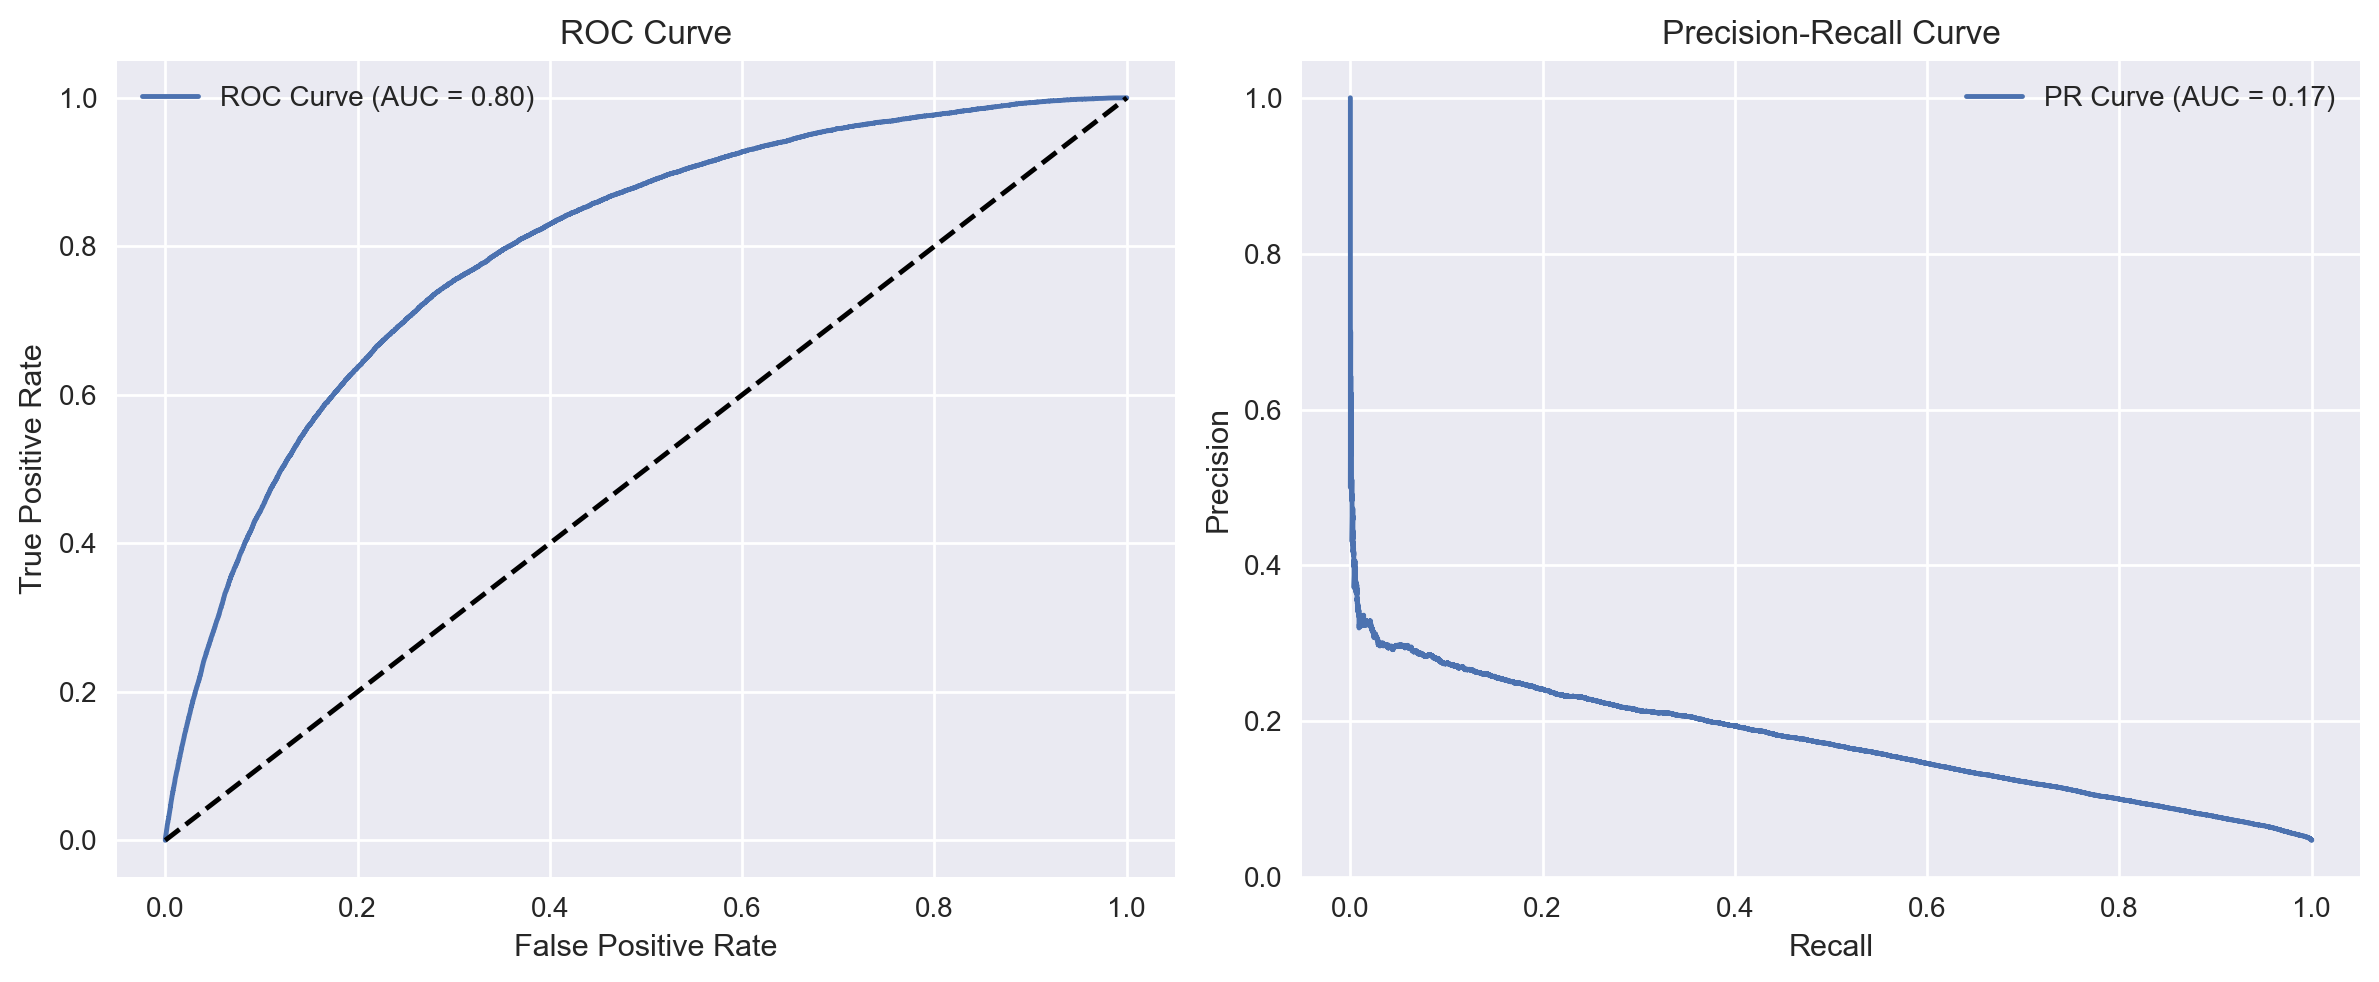

In [118]:
# анализ качества модели с подбором гиперпараметров
model_analysis(final_model, X_test, y_test)

Разницы в метриках нет, уличшить модель через подбор гиперпараметров не получилось.

Сохраним начальную модель.

In [ ]:
## Сохранение обученной модели

# формат .joblib
joblib.dump(model, 'models/logistic_regression_model.joblib')
# формат .pkl
with open('models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# CatBoost

In [ ]:
## Работа с признаками

# переводим значения категориальных признаков в строковый тип
for col in cat_features:
    df[col] = df[col].astype(str)

# разделение на признаки и целевую переменную
X = df.drop('target', axis=1)
y = df['target']

# разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y  
)

# cоздание Pool объектов (оптимизированный формат данных для CatBoost)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [122]:
%%time
## Обучение модели

# параметры модели с учетом дисбаланса
params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': RANDOM_STATE,
    'verbose': 100,
    'auto_class_weights': 'Balanced',  
    'eval_metric': 'AUC',  
    'early_stopping_rounds': 50
}

# обучение модели
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=test_pool)

0:	test: 0.8061703	best: 0.8061703 (0)	total: 795ms	remaining: 13m 14s
100:	test: 0.8505368	best: 0.8505368 (100)	total: 45.1s	remaining: 6m 41s
200:	test: 0.8582363	best: 0.8582363 (200)	total: 1m 26s	remaining: 5m 43s
300:	test: 0.8621805	best: 0.8621805 (300)	total: 2m 9s	remaining: 5m 1s
400:	test: 0.8655433	best: 0.8655433 (400)	total: 2m 52s	remaining: 4m 18s
500:	test: 0.8672760	best: 0.8672760 (500)	total: 3m 37s	remaining: 3m 36s
600:	test: 0.8684287	best: 0.8684287 (600)	total: 4m 23s	remaining: 2m 55s
700:	test: 0.8693199	best: 0.8693199 (700)	total: 5m 5s	remaining: 2m 10s
800:	test: 0.8700812	best: 0.8700812 (800)	total: 5m 46s	remaining: 1m 26s
900:	test: 0.8708180	best: 0.8708180 (900)	total: 6m 28s	remaining: 42.7s
999:	test: 0.8713530	best: 0.8713530 (999)	total: 7m 10s	remaining: 0us

bestTest = 0.8713529838
bestIteration = 999



ROC-AUC: 0.8714
PR-AUC: 0.2414
Average Precision: 0.2415


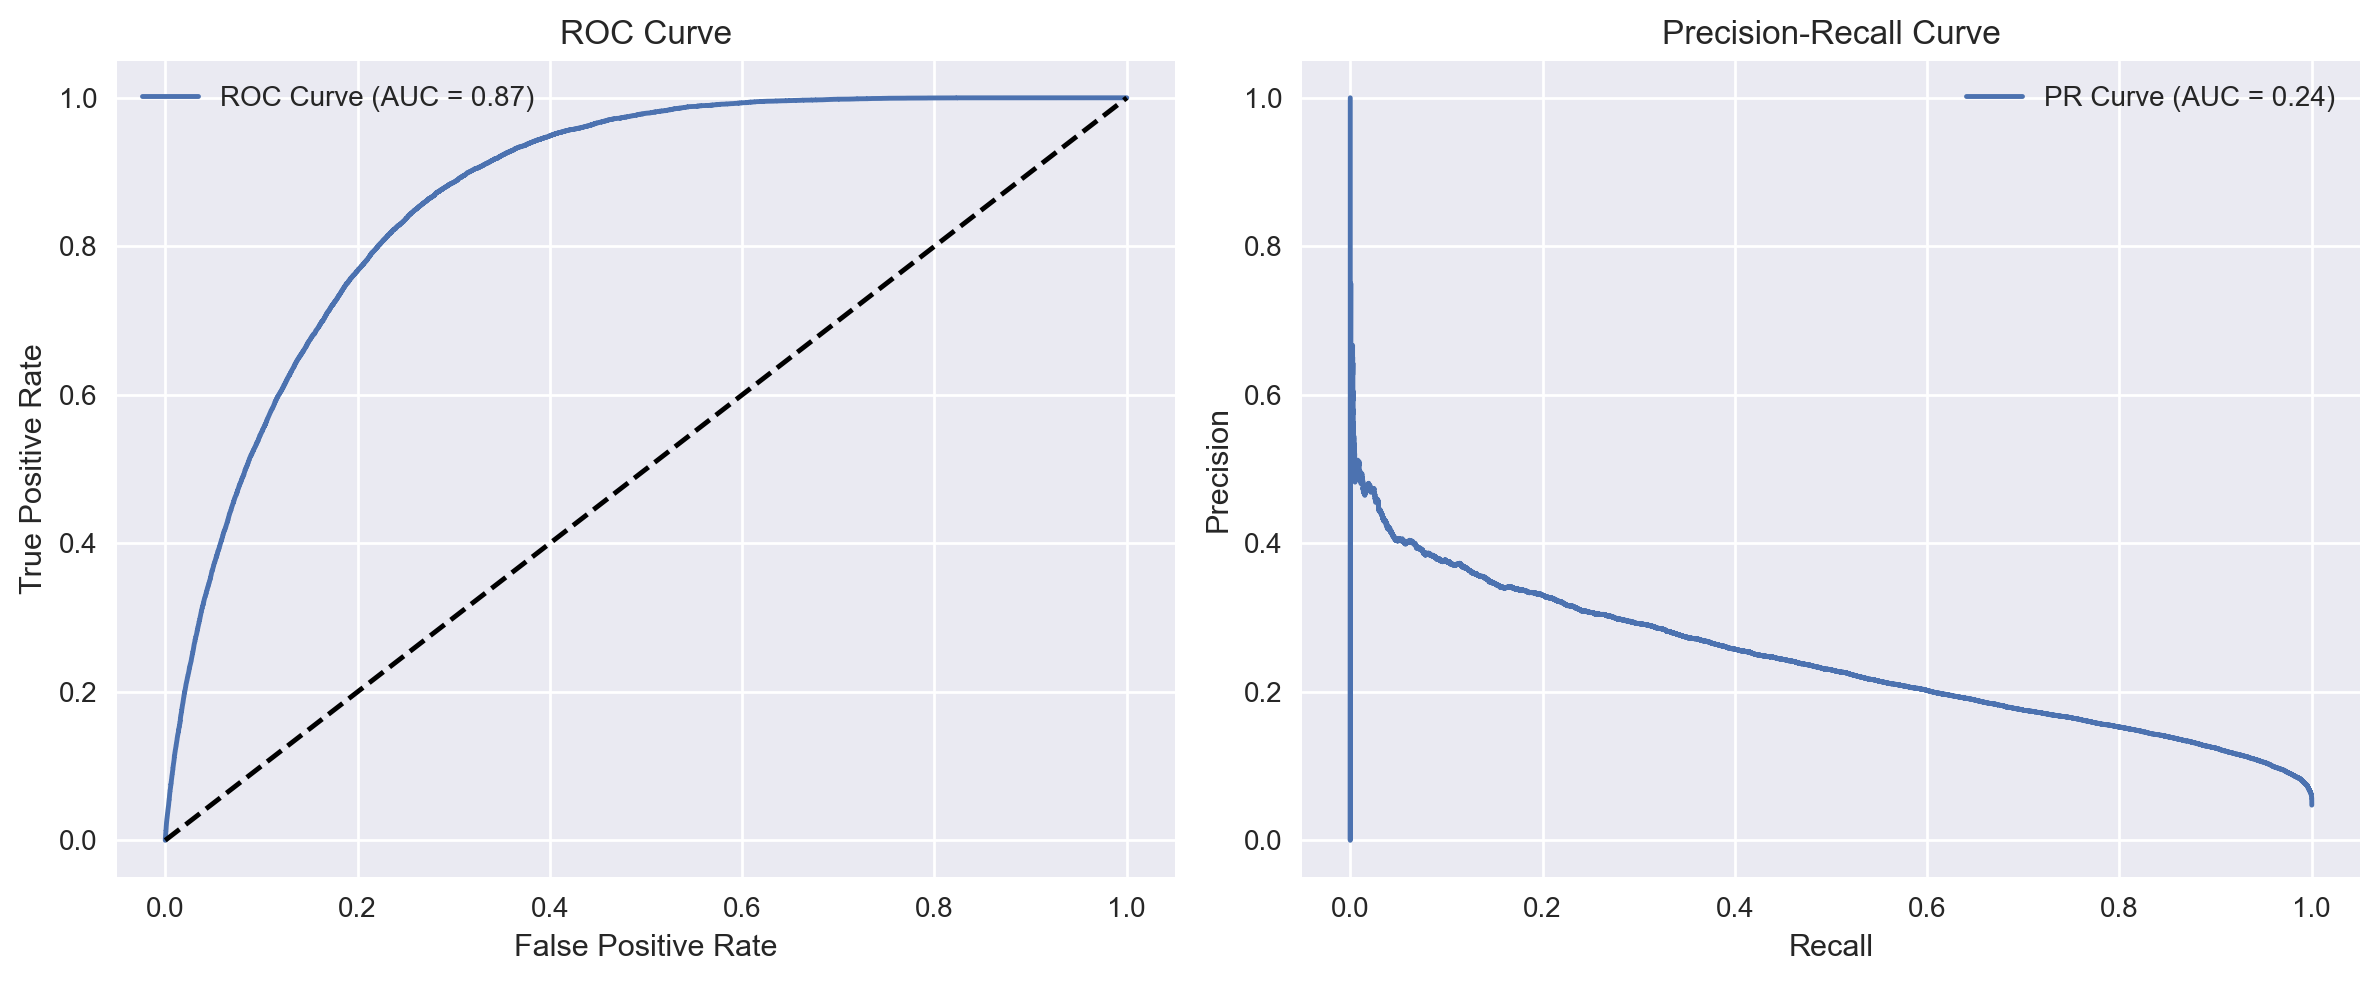

In [123]:
# анализ качества модели 
model_analysis(model, X_test, y_test)

Метрика значительно улучшилась.

Сохраним обученную модель.

In [ ]:
## Сохранение обученной модели

# бинарный формат
model.save_model('models/catboost_model.cbm')  
# формат .json
model.save_model('models/catboost_model.json', format='json')  
# формат .pkl
with open('models/catboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)


# Gradient Boosting

In [124]:
%%time
# параметры модели с учетом дисбаланса
params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_samples_split': 20,
    'min_samples_leaf': 10,
    'max_features': 'sqrt',
    'subsample': 0.8,
    'random_state': RANDOM_STATE
}

# обучение модели
model = make_pipeline(
    # обработка данных
    preprocessor,
    # baseline модель логистической регрессии
    GradientBoostingClassifier(**params)
)
model.fit(X_train, y_train)

CPU times: user 56.7 s, sys: 5.19 s, total: 1min 1s
Wall time: 1min 3s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['event_categories_number',
                                                   'hit_number_median']),
                                                 ('cat', OneHotEncoder(),
                                                  ['top_car_brand',
                                                   'visit_number', 'utm_source',
                                                   'utm_medium',
                                                   'device_category',
                                                   'device_brand',
                                                   'device_browser',
                                                   'geo_country', 'geo_city',
                                                   'month', 'day_of_week',
                                                   'time_of_day',
                                                   'top_car_brand_visit_number_1_1.0',
                                                   'top_car_brand_device_category_1_mobile_device',
                                                   'top_car_brand_geo_country_1_russia',
                                                   'geo_country_month_russia_10'])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            max_features='sqrt',
                                            min_samples_leaf=10,
                                            min_samples_split=20,
                                            n_estimators=200, random_state=42,
                                            subsample=0.8))])

ROC-AUC: 0.8372
PR-AUC: 0.1965
Average Precision: 0.1966


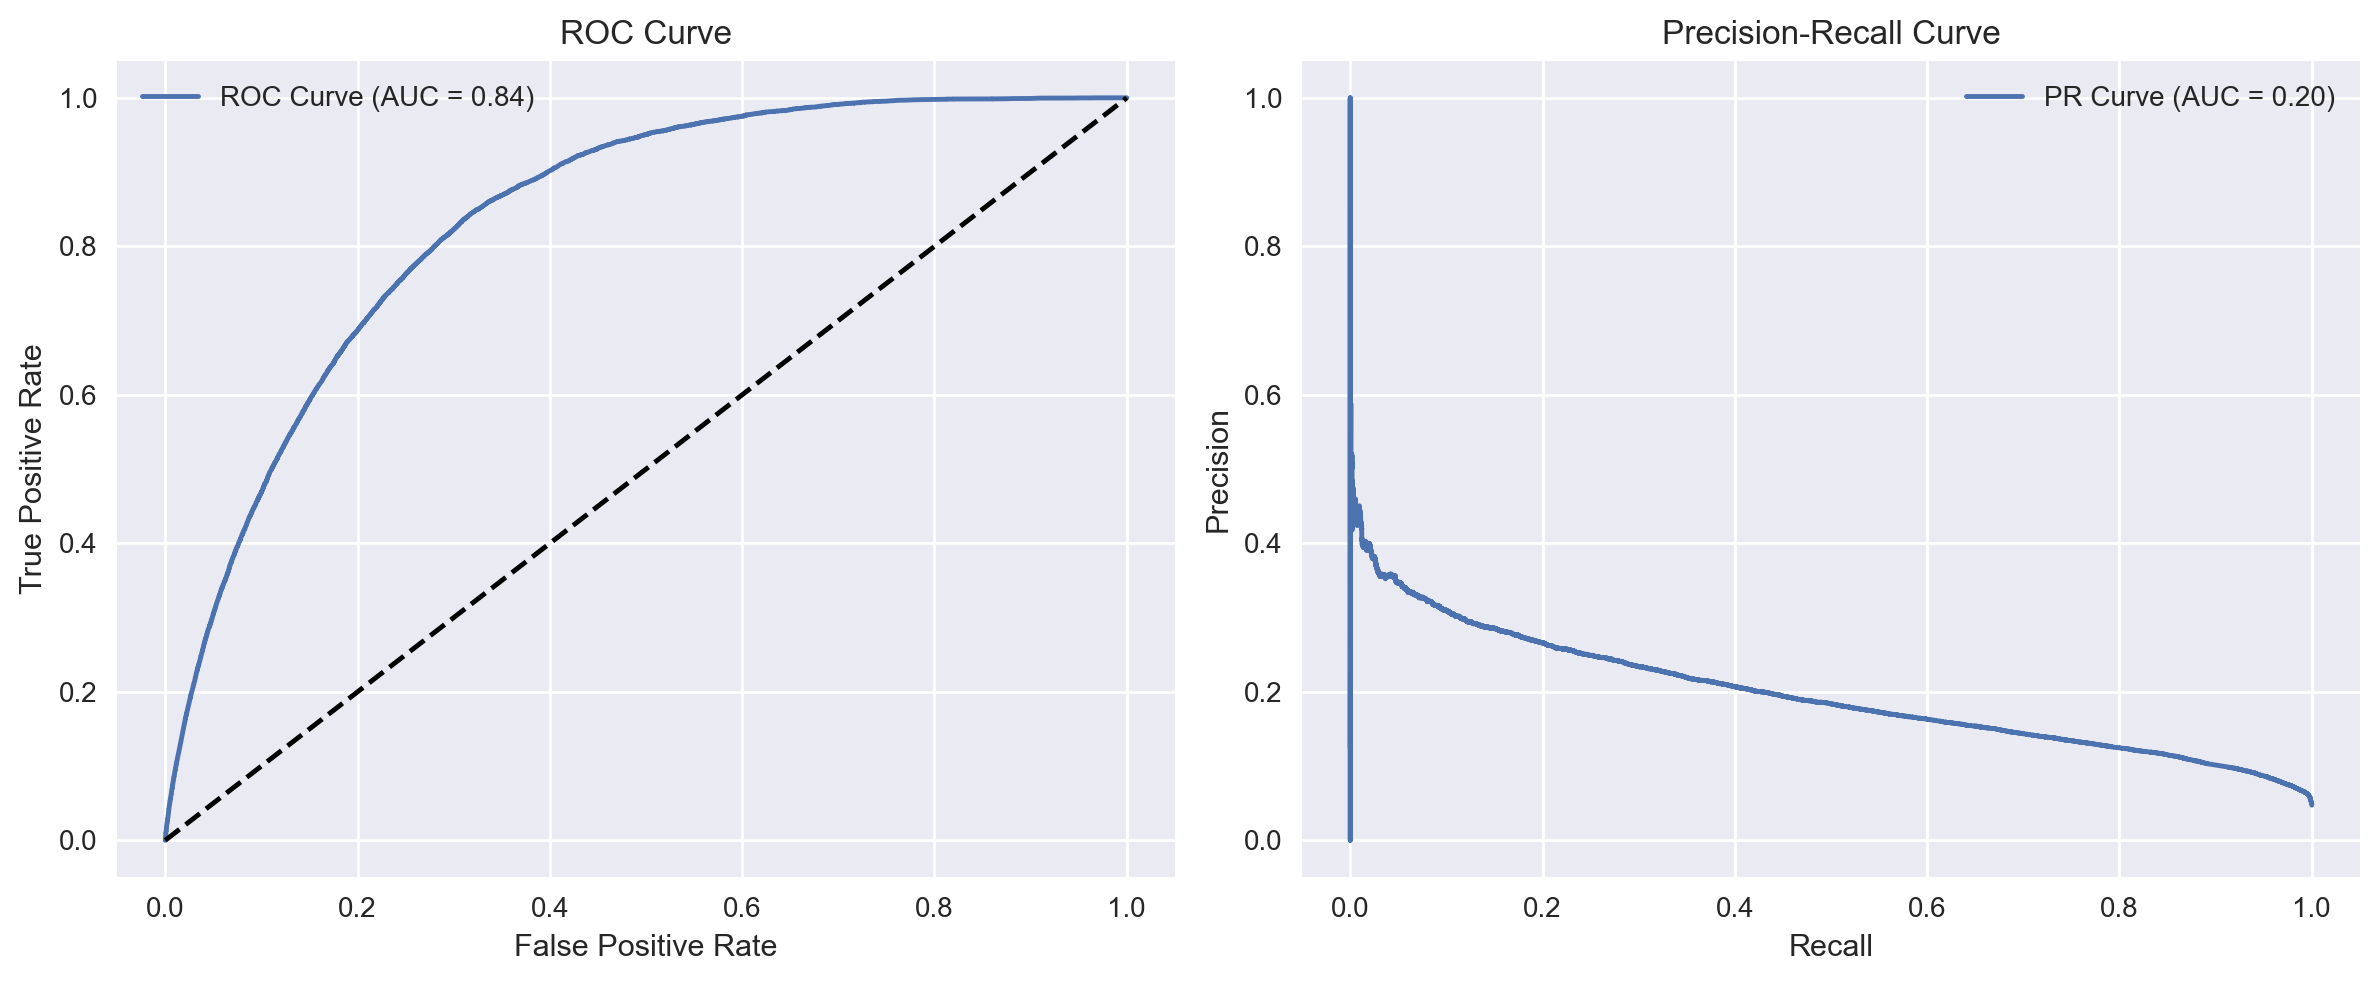

In [125]:
# анализ качества модели 
model_analysis(model, X_test, y_test)

Качество лучше, чем у логистической регресси, но хуже, чем у CatBoost.

Сохраним обученную модель.

In [ ]:
## Сохранение обученной модели

# формат .joblib
joblib.dump(model, 'models/gb_model.joblib')
# формат .pkl
with open('models/gb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# LightGBM

In [ ]:
# повторная загрузка датасета
df = pd.read_csv('data/dataset_for_ml.csv')

In [126]:
## Работа с признаками

# преобразование категориальных признаков для модели LightGBM
for col in cat_features:
    if col in df.columns:
        # Вариант 1: Label Encoding
        #le = LabelEncoder()
        #df[col] = le.fit_transform(df[col].astype(str))
        
        # Вариант 2: Преобразование в category (работает в LightGBM)
        df[col] = df[col].astype('category')

# разделение на признаки и целевую переменную
X = df.drop('target', axis=1)  # Замените 'target' на имя вашей целевой переменной
y = df['target']

# разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Указание категориальных признаков (для варианта с category)
categorical_features = list(X_train.select_dtypes(include=['category']).columns)

In [127]:
%%time
## Обучение модели

# параметры модели
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': ['auc', 'average_precision'],
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'scale_pos_weight': len(y_train[y_train==0]) / len(y_train[y_train==1]),
    'random_state': RANDOM_STATE
}

# создание Dataset
train_data = lgb.Dataset(
    X_train, 
    label=y_train,
    categorical_feature=categorical_features  # только если использовался astype('category')
)

# обучение модели
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[lgb.Dataset(X_test, y_test)]
)

CPU times: user 4min 43s, sys: 1min 37s, total: 6min 20s
Wall time: 42.6 s


ROC-AUC: 0.8739
PR-AUC: 0.2507
Average Precision: 0.2507


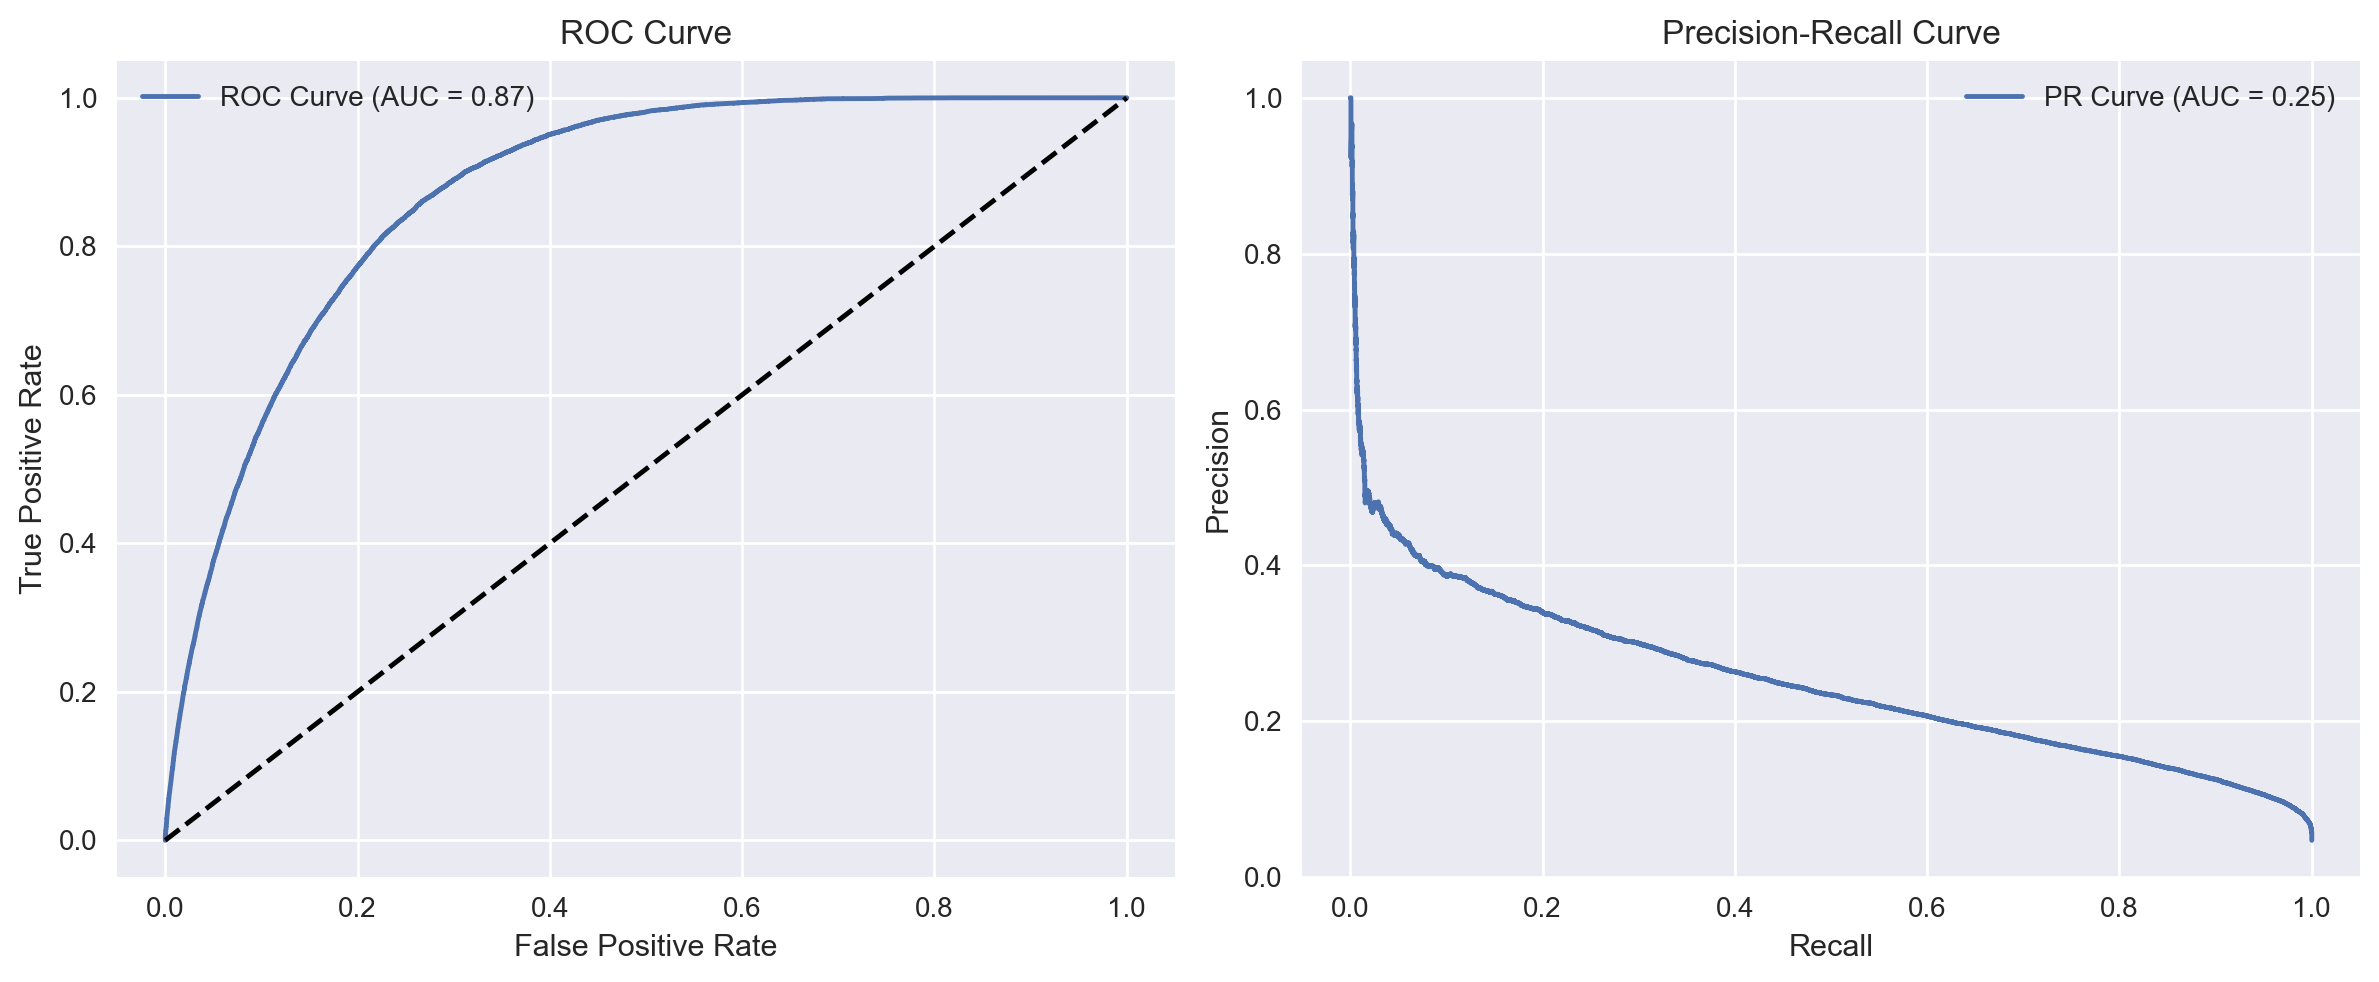

In [129]:
# анализ качества модели 
model_analysis(model, X_test, y_test, probabilities=False)

Лучшая модель по метрикам.

Сохраним обученную модель.

In [ ]:
## Сохранение обученной модели

# формат .txt
model.save_model('models/lightgbm_model.txt')
# формат .joblib
joblib.dump(model, 'models/lightgbm_model.joblib')
# формат .pkl
with open('models/lightgbm_model.pkl', 'wb') as f:
    pickle.dump(model, f)
